In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
  
  
def window_dataset(series, window_size, batch_size=128,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [3]:
# Read in data
spy = pd.read_csv('SPY.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 6949


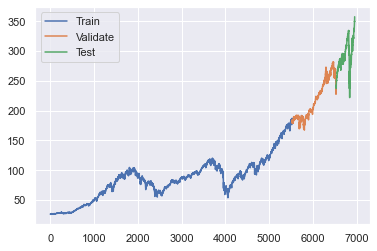

In [4]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [5]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [6]:
# Clear any back end stored data due to multiple iterations
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size
window_size = 30

# Create 2D batches of batch size and features (1 feature = 1 time step in window)
train_set = window_dataset(normalized_x_train, window_size, batch_size=128)

# Establish Model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                      input_shape=[None]), 
  keras.layers.SimpleRNN(100, return_sequences=True), 
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1), 
])

# create standard learning rate scheduler
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

# establish optimizer
optimizer = keras.optimizers.Nadam(lr=1e-7)

# Put model all together
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\Lenovo\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


43/43 [==============================] - 6s 69ms/step - loss: 0.0200 - mae: 0.1493 - lr: 1.0000e-05
Epoch 2/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0130 - mae: 0.1190 - lr: 1.1220e-05
Epoch 3/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0052 - mae: 0.0707 - lr: 1.2589e-05
Epoch 4/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0023 - mae: 0.0452 - lr: 1.4125e-05
Epoch 5/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0012 - mae: 0.0321 - lr: 1.5849e-05
Epoch 6/100
43/43 [==============================] - 1s 16ms/step - loss: 6.5596e-04 - mae: 0.0238 - lr: 1.7783e-05
Epoch 7/100
43/43 [==============================] - 1s 16ms/step - loss: 4.4538e-04 - mae: 0.0196 - lr: 1.9953e-05
Epoch 8/100
43/43 [==============================] - 1s 15ms/step - loss: 3.4397e-04 - mae: 0.0180 - lr: 2.2387e-05
Epoch 9/100
43/43 [==============================] - 1s 16ms/step - loss: 2.8254e-04 - mae: 0.0169 - lr:

(1e-05, 1.0, 0.0, 0.1)

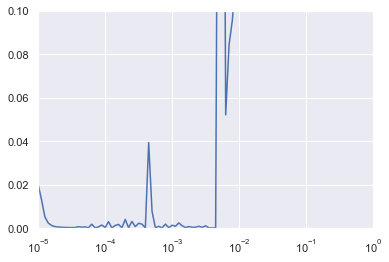

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, .1])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(normalized_x_train, window_size, batch_size=128)
valid_set = window_dataset(normalized_x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
])
optimizer = keras.optimizers.Nadam(lr=5e-5)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Set early stopping to prevent over fitting
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# save best model to load later
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# compile model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
     41/Unknown - 3s 18ms/step - loss: 0.0055 - mae: 0.0783INFO:tensorflow:Assets written to: my_checkpoint\assets
43/43 [==============================] - 9s 163ms/step - loss: 0.0054 - mae: 0.0782 - val_loss: 0.1909 - val_mae: 0.5187
Epoch 2/500
43/43 [==============================] - 6s 143ms/step - loss: 0.0013 - mae: 0.0361 - val_loss: 0.1030 - val_mae: 0.3616
Epoch 3/500
43/43 [==============================] - 6s 149ms/step - loss: 8.0252e-04 - mae: 0.0311 - val_loss: 0.0831 - val_mae: 0.3203
Epoch 4/500
43/43 [==============================] - 6s 143ms/step - loss: 4.7788e-04 - mae: 0.0226 - val_loss: 0.0702 - val_mae: 0.2894
Epoch 5/500
43/43 [==============================] - 6s 135ms/step - loss: 3.7628e-04 - mae: 0.0200 - val_loss: 0.0556 - val_mae: 0.2438
Epoch 6/500
43/43 [==============================] - 6s 139ms/step - loss: 5.9004e-04 - mae: 0.0258 - val_loss: 0.0537 - val_mae: 0.2443
Epoch 7/500
43/43 [==============================] - 7s 157ms/step - lo

43/43 [==============================] - 6s 146ms/step - loss: 7.8350e-05 - mae: 0.0093 - val_loss: 0.0145 - val_mae: 0.1188
Epoch 37/500
43/43 [==============================] - 1s 28ms/step - loss: 1.9617e-04 - mae: 0.0154 - val_loss: 0.0173 - val_mae: 0.1411
Epoch 38/500
43/43 [==============================] - 6s 150ms/step - loss: 7.0999e-05 - mae: 0.0088 - val_loss: 0.0139 - val_mae: 0.1165
Epoch 39/500
43/43 [==============================] - 6s 144ms/step - loss: 6.8993e-05 - mae: 0.0085 - val_loss: 0.0132 - val_mae: 0.1124
Epoch 40/500
43/43 [==============================] - 1s 27ms/step - loss: 7.8101e-05 - mae: 0.0092 - val_loss: 0.0137 - val_mae: 0.1172
Epoch 41/500
43/43 [==============================] - 6s 144ms/step - loss: 1.6947e-04 - mae: 0.0141 - val_loss: 0.0115 - val_mae: 0.1043
Epoch 42/500
43/43 [==============================] - 1s 30ms/step - loss: 1.0612e-04 - mae: 0.0112 - val_loss: 0.0136 - val_mae: 0.1177
Epoch 43/500
43/43 [==============================

Epoch 84/500
43/43 [==============================] - 6s 137ms/step - loss: 8.9380e-05 - mae: 0.0099 - val_loss: 0.0060 - val_mae: 0.0740
Epoch 85/500
43/43 [==============================] - 1s 23ms/step - loss: 5.4420e-05 - mae: 0.0078 - val_loss: 0.0072 - val_mae: 0.0844
Epoch 86/500
43/43 [==============================] - 1s 29ms/step - loss: 5.0182e-05 - mae: 0.0073 - val_loss: 0.0070 - val_mae: 0.0823
Epoch 87/500
43/43 [==============================] - 1s 23ms/step - loss: 4.0770e-05 - mae: 0.0066 - val_loss: 0.0071 - val_mae: 0.0828
Epoch 88/500
43/43 [==============================] - 2s 35ms/step - loss: 8.8765e-05 - mae: 0.0099 - val_loss: 0.0086 - val_mae: 0.0998
Epoch 89/500
43/43 [==============================] - 1s 26ms/step - loss: 9.2458e-05 - mae: 0.0103 - val_loss: 0.0083 - val_mae: 0.0968
Epoch 90/500
43/43 [==============================] - 1s 25ms/step - loss: 4.0912e-05 - mae: 0.0067 - val_loss: 0.0064 - val_mae: 0.0773
Epoch 91/500
43/43 [====================

43/43 [==============================] - 1s 30ms/step - loss: 2.5777e-05 - mae: 0.0051 - val_loss: 0.0020 - val_mae: 0.0428
Epoch 190/500
43/43 [==============================] - 1s 25ms/step - loss: 2.5858e-05 - mae: 0.0052 - val_loss: 0.0021 - val_mae: 0.0431
Epoch 191/500
43/43 [==============================] - 6s 135ms/step - loss: 7.6232e-05 - mae: 0.0090 - val_loss: 0.0018 - val_mae: 0.0409
Epoch 192/500
43/43 [==============================] - 1s 23ms/step - loss: 2.5449e-05 - mae: 0.0052 - val_loss: 0.0019 - val_mae: 0.0411
Epoch 193/500
43/43 [==============================] - 1s 23ms/step - loss: 2.7244e-05 - mae: 0.0053 - val_loss: 0.0023 - val_mae: 0.0466
Epoch 194/500
43/43 [==============================] - 1s 23ms/step - loss: 3.2363e-05 - mae: 0.0058 - val_loss: 0.0029 - val_mae: 0.0569
Epoch 195/500
43/43 [==============================] - 1s 23ms/step - loss: 2.5462e-05 - mae: 0.0051 - val_loss: 0.0021 - val_mae: 0.0433
Epoch 196/500
43/43 [==========================

43/43 [==============================] - 1s 24ms/step - loss: 2.4744e-05 - mae: 0.0051 - val_loss: 0.0011 - val_mae: 0.0306
Epoch 297/500
43/43 [==============================] - 1s 22ms/step - loss: 2.4063e-05 - mae: 0.0049 - val_loss: 0.0015 - val_mae: 0.0393
Epoch 298/500
43/43 [==============================] - 1s 22ms/step - loss: 2.7749e-05 - mae: 0.0052 - val_loss: 0.0010 - val_mae: 0.0311
Epoch 299/500
43/43 [==============================] - 1s 22ms/step - loss: 2.4098e-05 - mae: 0.0050 - val_loss: 0.0011 - val_mae: 0.0320
Epoch 300/500
43/43 [==============================] - 1s 23ms/step - loss: 2.0619e-05 - mae: 0.0044 - val_loss: 0.0014 - val_mae: 0.0367
Epoch 301/500
43/43 [==============================] - 2s 35ms/step - loss: 2.2838e-05 - mae: 0.0048 - val_loss: 0.0018 - val_mae: 0.0455
Epoch 302/500
43/43 [==============================] - 1s 30ms/step - loss: 2.2300e-05 - mae: 0.0047 - val_loss: 0.0013 - val_mae: 0.0351
Epoch 303/500
43/43 [===========================

43/43 [==============================] - 2s 38ms/step - loss: 2.7277e-05 - mae: 0.0054 - val_loss: 0.0015 - val_mae: 0.0406
Epoch 353/500
43/43 [==============================] - 1s 26ms/step - loss: 2.1578e-05 - mae: 0.0046 - val_loss: 0.0010 - val_mae: 0.0310
Epoch 354/500
43/43 [==============================] - 2s 40ms/step - loss: 2.2899e-05 - mae: 0.0048 - val_loss: 0.0011 - val_mae: 0.0324
Epoch 355/500
43/43 [==============================] - 1s 27ms/step - loss: 2.0516e-05 - mae: 0.0044 - val_loss: 0.0012 - val_mae: 0.0335
Epoch 356/500
43/43 [==============================] - 1s 28ms/step - loss: 2.9927e-05 - mae: 0.0054 - val_loss: 0.0016 - val_mae: 0.0441
Epoch 357/500
43/43 [==============================] - 1s 27ms/step - loss: 2.4952e-05 - mae: 0.0052 - val_loss: 9.7673e-04 - val_mae: 0.0302
Epoch 358/500
43/43 [==============================] - 1s 26ms/step - loss: 2.1580e-05 - mae: 0.0046 - val_loss: 8.9491e-04 - val_mae: 0.0285
Epoch 359/500
43/43 [===================

Epoch 410/500
43/43 [==============================] - 1s 26ms/step - loss: 2.1083e-05 - mae: 0.0046 - val_loss: 9.3604e-04 - val_mae: 0.0300
Epoch 411/500
43/43 [==============================] - 1s 24ms/step - loss: 2.5050e-05 - mae: 0.0050 - val_loss: 8.2845e-04 - val_mae: 0.0276
Epoch 412/500
43/43 [==============================] - 1s 23ms/step - loss: 2.3847e-05 - mae: 0.0048 - val_loss: 9.1320e-04 - val_mae: 0.0292
Epoch 413/500
43/43 [==============================] - 1s 24ms/step - loss: 2.0950e-05 - mae: 0.0045 - val_loss: 9.6360e-04 - val_mae: 0.0305
Epoch 414/500
43/43 [==============================] - 1s 26ms/step - loss: 2.0227e-05 - mae: 0.0044 - val_loss: 9.7261e-04 - val_mae: 0.0307
Epoch 415/500
43/43 [==============================] - 1s 25ms/step - loss: 2.0455e-05 - mae: 0.0044 - val_loss: 0.0012 - val_mae: 0.0355
Epoch 416/500
43/43 [==============================] - 1s 24ms/step - loss: 2.3646e-05 - mae: 0.0048 - val_loss: 0.0015 - val_mae: 0.0429
Epoch 417/500


In [9]:
model = keras.models.load_model("my_checkpoint")

In [10]:
rnn_forecast = model_forecast(
    model,
    spy_normalized_to_traindata[x_test.index.min() - window_size:-1],
    window_size)[:, 0]

14/14 [==============================] - 0s 8ms/step


In [11]:
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(422,)

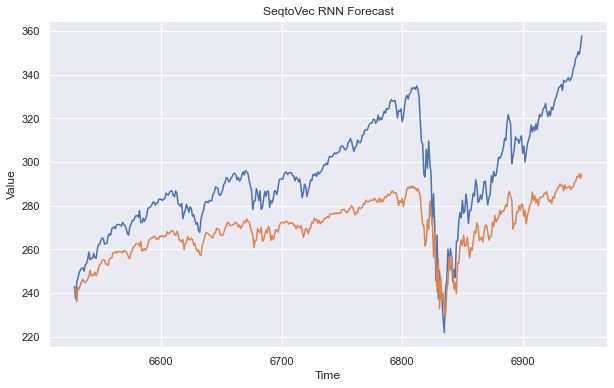

In [12]:
plt.figure(figsize=(10,6))

plt.title('SeqtoVec RNN Forecast')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test)
plot_series(x_test.index, rnn_unscaled_forecast)

In [13]:
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

23.70486

## Sequence-to-Sequence Forecasting

In [14]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

The cell below illustrates exactly what the function above is doing. the cell above creates batches and labels for those batches. The point Y[0] is the label for X[0] to try to calculate.

In [15]:
# Show example of what seq-seq looks like
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3, batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

# in the seq2seq_window we removed the need for the lambda layer to expand dimensions as it is already 3D 
train_set = seq2seq_window_dataset(normalized_x_train.flatten(), window_size,
                                   batch_size=128)

# Create model
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1), # now dense layer is applied at every time step
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 30))

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# create history callback from fit
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\Lenovo\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


43/43 [==============================] - 3s 21ms/step - loss: 0.0577 - mae: 0.2484 - lr: 1.0000e-05
Epoch 2/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0261 - mae: 0.1691 - lr: 1.0798e-05
Epoch 3/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0147 - mae: 0.1251 - lr: 1.1659e-05
Epoch 4/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0093 - mae: 0.0957 - lr: 1.2589e-05
Epoch 5/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0067 - mae: 0.0767 - lr: 1.3594e-05
Epoch 6/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0053 - mae: 0.0647 - lr: 1.4678e-05
Epoch 7/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0045 - mae: 0.0575 - lr: 1.5849e-05
Epoch 8/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0039 - mae: 0.0520 - lr: 1.7113e-05
Epoch 9/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0035 - mae: 0.0475 - lr: 1.8478e-05
Epoc

(1e-05, 1.0, 0.0, 0.1)

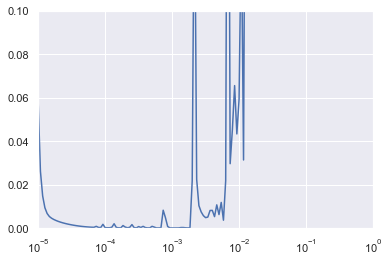

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, .1])

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train.flatten(), window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid.flatten(), window_size,
                                   batch_size=128)


model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
])


optimizer = keras.optimizers.Nadam(lr=1e-3)


model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


early_stopping = keras.callbacks.EarlyStopping(patience=20)


model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)


model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
     40/Unknown - 3s 15ms/step - loss: 0.0065 - mae: 0.0729INFO:tensorflow:Assets written to: my_checkpoint\assets
43/43 [==============================] - 8s 128ms/step - loss: 0.0072 - mae: 0.0782 - val_loss: 0.0058 - val_mae: 0.0863
Epoch 2/500
43/43 [==============================] - 6s 131ms/step - loss: 1.9874e-04 - mae: 0.0133 - val_loss: 0.0025 - val_mae: 0.0564
Epoch 3/500
43/43 [==============================] - 1s 18ms/step - loss: 2.4692e-04 - mae: 0.0117 - val_loss: 0.0065 - val_mae: 0.0836
Epoch 4/500
43/43 [==============================] - 6s 136ms/step - loss: 1.0095e-04 - mae: 0.0096 - val_loss: 0.0021 - val_mae: 0.0523
Epoch 5/500
43/43 [==============================] - 1s 23ms/step - loss: 5.2072e-05 - mae: 0.0070 - val_loss: 0.0031 - val_mae: 0.0655
Epoch 6/500
43/43 [==============================] - 1s 22ms/step - loss: 1.3083e-04 - mae: 0.0088 - val_loss: 0.0253 - val_mae: 0.2082
Epoch 7/500
43/43 [==============================] - 1s 20ms/step - lo

Epoch 54/500
43/43 [==============================] - 1s 17ms/step - loss: 4.0003e-05 - mae: 0.0059 - val_loss: 0.0014 - val_mae: 0.0475
Epoch 55/500
43/43 [==============================] - 1s 17ms/step - loss: 6.9722e-05 - mae: 0.0076 - val_loss: 0.0027 - val_mae: 0.0686
Epoch 56/500
43/43 [==============================] - 1s 18ms/step - loss: 7.8504e-05 - mae: 0.0082 - val_loss: 0.0040 - val_mae: 0.0848
Epoch 57/500
43/43 [==============================] - 1s 17ms/step - loss: 2.7291e-04 - mae: 0.0123 - val_loss: 0.0079 - val_mae: 0.1189
Epoch 58/500
43/43 [==============================] - 1s 18ms/step - loss: 7.0012e-05 - mae: 0.0081 - val_loss: 9.9410e-04 - val_mae: 0.0376
Epoch 59/500
43/43 [==============================] - 1s 18ms/step - loss: 3.2799e-05 - mae: 0.0056 - val_loss: 0.0024 - val_mae: 0.0633
Epoch 60/500
43/43 [==============================] - 1s 20ms/step - loss: 2.4961e-05 - mae: 0.0051 - val_loss: 5.8787e-04 - val_mae: 0.0267
Epoch 61/500
43/43 [=============

In [19]:
# recall best model
model = keras.models.load_model("my_checkpoint")

In [20]:
# create forecast and clip to only show test values
rnn_forecast = model_forecast(model, spy_normalized_to_traindata.flatten()[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[x_test.index.min() - window_size:-1, -1, 0]

217/217 [==============================] - 1s 3ms/step


In [21]:
# Get data back to normal scale
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(422,)

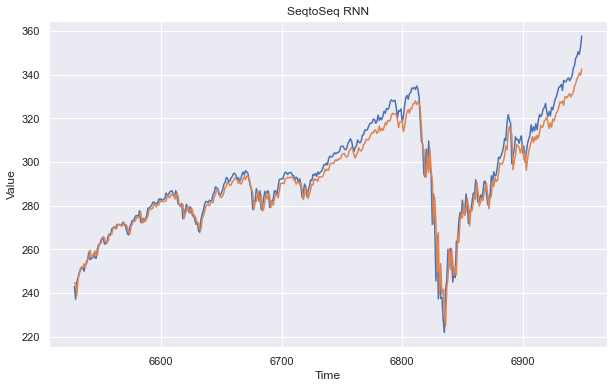

In [22]:
# Plot results
plt.figure(figsize=(10, 6))
plt.title('SeqtoSeq RNN')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plot_series(x_test.index, x_test)
plot_series(x_test.index, rnn_unscaled_forecast)

In [23]:
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

4.193623